# spikeRNN: Tutorials

This notebook provides a complete walkthrough of the `spikeRNN` framework, from training a rate-based RNN to converting it into a functional spiking RNN for the Go-Nogo Task.

The workflow is divided into four main parts:

1.  **Part 1: Training a Rate-based RNN**: We'll train a continuous rate model on the Go-NoGo cognitive task,
2.  **Part 2: Saving the Trained Model**: The parameters of the trained rate model are saved to a `.mat` file for conversion,
3.  **Part 3: Converting to a Spiking RNN**: We'll use the saved model to construct a leaky integrate-and-fire (LIF) spiking network.,
4.  **Part 4: Evaluating the Spiking Network**: Finally, we'll evaluate the performance of the spiking network and visualize its activity.

## Part 0: Installation

- Before running the tutorial, we need to install the `spikeRNN` package.

In [ ]:
import sys
!{sys.executable} -m pip install -e ..

#### Setup: Imports and Configuration

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
import torch
import scipy.io as sio
import matplotlib.pyplot as plt
from rate import FR_RNN_dale, set_gpu, create_default_config
from rate.model import generate_input_stim_go_nogo, generate_target_continuous_go_nogo, loss_op
from spiking.LIF_network_fnc import LIF_network_fnc
from spiking.lambda_grid_search import lambda_grid_search

import warnings
warnings.filterwarnings('ignore')

## Part 1: Training a Rate-based RNN

First, we'll configure and train a rate-based recurrent neural network with Dale's principle on the Go-NoGo task. The network learns to produce a high output for a 'Go' stimulus and maintain a low output for a 'NoGo' stimulus (i.e., no stimulus).

In [2]:
# Set up GPU if available, otherwise use CPU
device = set_gpu('0', 0.3)
# Configure network parameters
N = 200      # Number of neurons
P_inh = 0.2  # Proportion of inhibitory neurons
P_rec = 0.2  # Recurrent connection probability
config = create_default_config(N=N, P_inh=P_inh, P_rec=P_rec)

# Initialize network
w_in = torch.randn(200, 1, device=device)
w_out = torch.randn(1, 200, device=device) / 100

net = FR_RNN_dale(
    N=config.N,
    P_inh=config.P_inh,
    P_rec=config.P_rec,
    w_in=w_in,
    w_out=w_out,
    som_N=0, # No SOM neurons for this task
    w_dist='gaus', 
    gain=1.5, 
    apply_dale=True,
    device=device
)

# Generate task data
settings = {'T': 200, 'stim_on': 50, 'stim_dur': 25, 'DeltaT': 1,
           'taus': [10], 'task': 'go-nogo'}
u, label = generate_input_stim_go_nogo(settings)
target = generate_target_continuous_go_nogo(settings, label)


In [3]:
# Set up training parameters
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
num_trials = 10000

task_settings = {
    'T': 200, 
    'stim_on': 50, 
    'stim_dur': 25, 
    'DeltaT': 1, 
    'task': 'go-nogo',
    'taus': [10]
}

training_params = {
        'learning_rate': 0.01, # learning rate
        'loss_threshold': 7, # loss threshold (when to stop training)
        'eval_freq': 100, # how often to evaluate task perf
        'eval_tr': 100, # number of trials for eval
        'eval_amp_threh': 0.7, # amplitude threshold during response window
        'activation': 'sigmoid', # activation function
        'loss_fn': 'L1', # loss function ('L1' or 'L2')
        'P_rec': 0.20
        }

losses = []

u, label = generate_input_stim_go_nogo(task_settings)
u_tensor = torch.tensor(u, dtype=torch.float32, device=device)
# Get initial network outputs
stim0, x0, r0, o0, w0, w_in0, m0, som_m0, w_out0, b_out0, taus_gaus0 = \
            net.forward(u_tensor, settings['taus'], training_params, settings)


print("Starting rate RNN training...")
# Run the training loop
for trial in range(num_trials):
    optimizer.zero_grad()
    
    # Generate data
    u, label = generate_input_stim_go_nogo(task_settings)
    target = generate_target_continuous_go_nogo(task_settings, label)
    
    u_tensor = torch.tensor(u, dtype=torch.float32, device=device)
    target_tensor = torch.tensor(target, dtype=torch.float32, device=device)

    # Forward pass
    stim, x, r, o, w, w_in, m, som_m, w_out, b_out, taus_gaus = net.forward(u_tensor, task_settings['taus'], training_params, task_settings)
    
    # Compute loss
    loss = loss_op(o, target, training_params)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

print("Training complete.")

Starting rate RNN training...
Training complete.


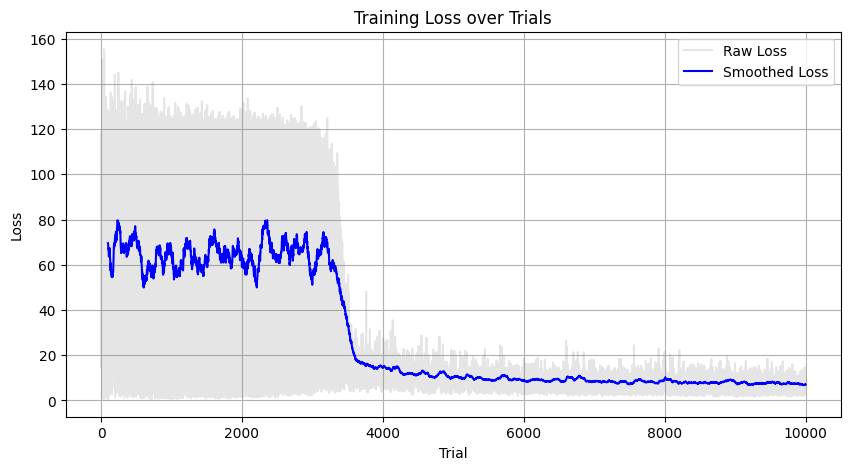

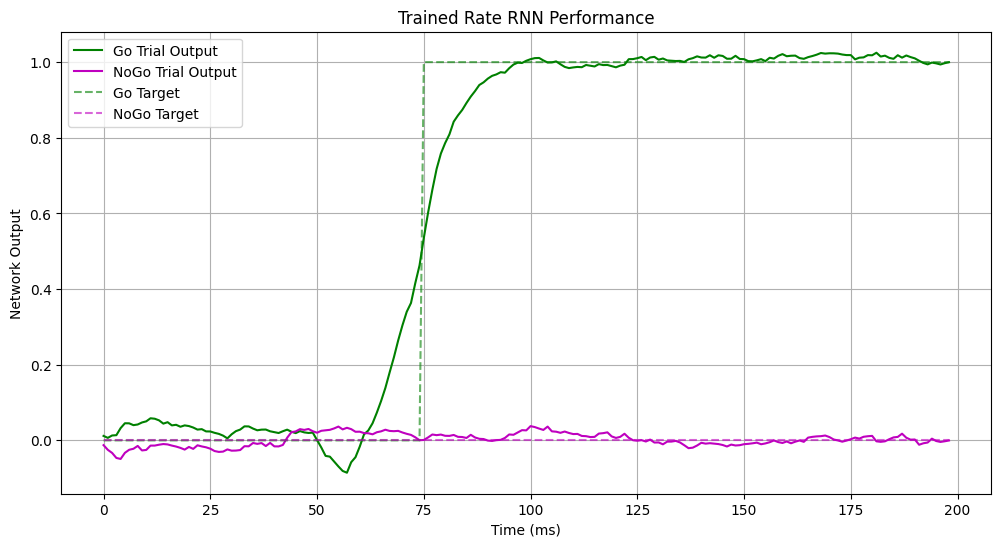

In [4]:
plt.figure(figsize=(10, 5))

window_size = 100  # adjust this value to change smoothing amount
smoothed_losses = pd.Series(losses).rolling(window=window_size).mean()

plt.plot(losses, alpha=0.2, color='gray', label='Raw Loss')
plt.plot(smoothed_losses, color='blue', label='Smoothed Loss')

plt.title('Training Loss over Trials')
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Test the trained network
net.eval() # Set network to evaluation mode
with torch.no_grad():
    # ---------- Go trial ----------
    u_go = np.zeros((1, task_settings['T']))
    go_start = task_settings['stim_on']
    go_end   = go_start + task_settings['stim_dur']
    u_go[0, go_start:go_end] = 1.0          # Add stimulus
    label_go = 1

    u_go_tensor = torch.tensor(u_go, dtype=torch.float32, device=device)
    full_out_go = net.forward(u_go_tensor,
                              task_settings['taus'],
                              training_params,
                              task_settings)
    go_o_list = full_out_go[3]               # list of output tensors
    go_out = torch.stack(go_o_list).squeeze().t()  # shape (1,T-1)

    # ---------- NoGo trial ----------
    u_nogo = np.zeros((1, task_settings['T']))      # no stimulus
    label_nogo = 0

    u_nogo_tensor = torch.tensor(u_nogo, dtype=torch.float32, device=device)
    full_out_nogo = net.forward(u_nogo_tensor,
                                task_settings['taus'],
                                training_params,
                                task_settings)
    nogo_o_list = full_out_nogo[3]
    nogo_out = torch.stack(nogo_o_list).squeeze().t()

# Plot results
time_pts = np.arange(task_settings['T'] - 1) * task_settings['DeltaT']

plt.figure(figsize=(12, 6))
plt.plot(time_pts, go_out.cpu().numpy().flatten(),
         'g', label='Go Trial Output')
plt.plot(time_pts, nogo_out.cpu().numpy().flatten(),
         'm', label='NoGo Trial Output')
plt.plot(time_pts,
         generate_target_continuous_go_nogo(task_settings, label_go),
         'g--', alpha=0.6, label='Go Target')
plt.plot(time_pts,
         generate_target_continuous_go_nogo(task_settings, label_nogo),
         'm--', alpha=0.6, label='NoGo Target')
plt.title('Trained Rate RNN Performance')
plt.xlabel('Time (ms)')
plt.ylabel('Network Output')
plt.legend()
plt.grid(True)
plt.show()

## Part 2: Saving the Trained Model

To prepare for conversion to a spiking network, we need to save all the relevant weights and network parameters into a `.mat` file. The `LIF_network_fnc` will load this file.


In [5]:
model_filename = 'rate_model_go_nogo.mat'
model_dir = '../models/go-nogo'
os.makedirs('../models/go-nogo', exist_ok=True)

model_path = os.path.join(model_dir, model_filename)

model_dict = {
    'w': net.w.detach().cpu().numpy(),
    'w_in': net.w_in.detach().cpu().numpy(),
    'w_out': net.w_out.detach().cpu().numpy(),
    'w0': w0.detach().cpu().numpy(),
    'N': np.array(net.N),
    'm': net.mask.cpu().numpy(),
    'som_m': net.som_mask.cpu().numpy(),
    'inh': net.inh,
    'exc': net.exc,
    'taus': np.array(task_settings['taus']),
    'taus_gaus': taus_gaus.detach().cpu().numpy(),
    'taus_gaus0': taus_gaus0.detach().cpu().numpy(),
}
sio.savemat(model_path, model_dict)

print(f"Trained rate model saved to: {model_path}")

Trained rate model saved to: ../models/go-nogo/rate_model_go_nogo.mat


## Part 3: Converting to a Spiking RNN 

Now we convert the trained rate model into a spiking LIF network. A critical parameter in this conversion is the scaling factor (lambda), which maps the continuous rate values to the input currents of the LIF neurons.

### Finding the optimal sacling factor (lambda)

- The performance of the resulting spiking network is highly sensitive to the scaling factor. The `spikeRNN` package provides a function `lambda_grid_search` to find the optimal value by evaluating performance across a range of factors.

In [6]:
lambda_grid_search(
    model_dir='../models/go-nogo',
    task_name='go-nogo',
    n_trials=50,
    scaling_factors=list(np.arange(15, 76, 5))
)

Analyzing rate_model_go_nogo.mat
Testing scaling factor: 25
Performance for 25: 0.840
Testing scaling factor: 30
Performance for 30: 0.840
Testing scaling factor: 35
Performance for 35: 0.760
Testing scaling factor: 40
Performance for 40: 0.540
Testing scaling factor: 45
Performance for 45: 0.780
Testing scaling factor: 50
Performance for 50: 0.320
Testing scaling factor: 55
Performance for 55: 0.580
Testing scaling factor: 60
Performance for 60: 0.520
Testing scaling factor: 65
Performance for 65: 0.440
Testing scaling factor: 70
Performance for 70: 0.480
Testing scaling factor: 75
Performance for 75: 0.560
Best scaling factor: 25
Saved results.


In [13]:
scaling_factor = 25.0
down_sample = 1        # No downsampling
use_initial_weights = False # Use trained weights

print(f"Using scaling factor: {scaling_factor}")

# --- NoGo Trial Simulation ---
u_nogo_sim = np.zeros((1, 201)) # Input stimulus for simulation
stims = {'mode': 'none'}

print("Running LIF simulation for NoGo trial...")
W_nogo, REC_nogo, spk_nogo, rs_nogo, all_fr_nogo, out_nogo, params_nogo = LIF_network_fnc(
    model_path, scaling_factor, u_nogo_sim, stims, down_sample, use_initial_weights
)

# --- Go Trial Simulation ---
u_go_sim = np.zeros((1, 201))
u_go_sim[0, 50:75] = 1.0 # Stimulus for Go trial

print("Running LIF simulation for Go trial...")
W_go, REC_go, spk_go, rs_go, all_fr_go, out_go, params_go = LIF_network_fnc(
    model_path, scaling_factor, u_go_sim, stims, down_sample, use_initial_weights
)

print("Spiking network simulation complete.")

Using scaling factor: 25.0
Running LIF simulation for NoGo trial...
Running LIF simulation for Go trial...
Spiking network simulation complete.


## Part 4 - Evaluating the Spiking Network

We now evaluate the performance of our spiking LIF network and compare it with the original rate-based network. We will:

1. Plot the network outputs for Go and NoGo trials (rate vs. spiking).  
2. Visualize spike rasters to inspect the underlying population activity.

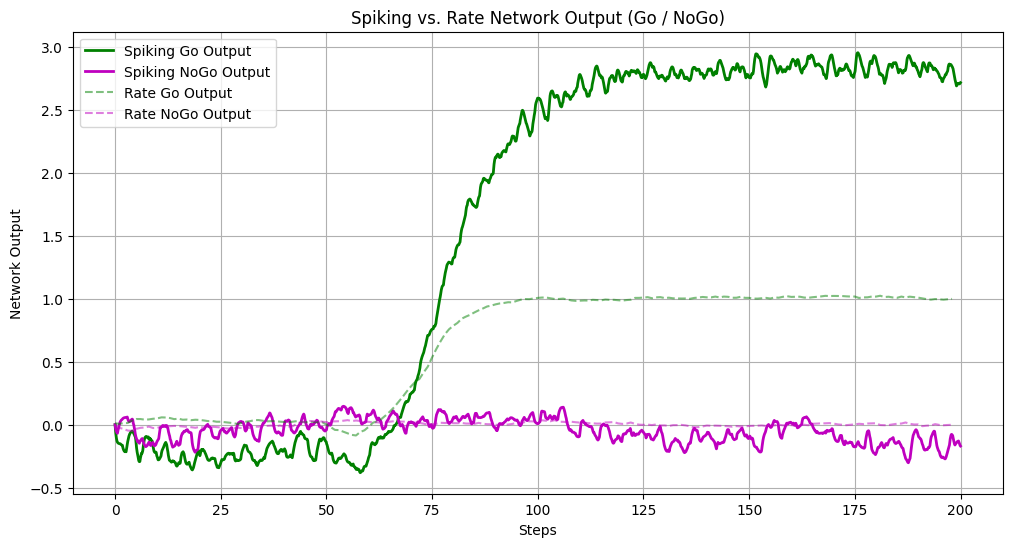

In [14]:
# Plot network output: spiking vs. rate
dt = params_go['dt']
T = params_go['T']
nt = params_go['nt']

t_spk = np.arange(dt, dt*(nt+1), dt)[:nt] * 200

# Time axis for the rate network (already in ms from Part 1/2)
time_rate = np.arange(task_settings['T'] - 1) * task_settings['DeltaT']

plt.figure(figsize=(12, 6))

# Spiking network outputs
plt.plot(t_spk, out_go.flatten(),
         'g',  linewidth=2, label='Spiking Go Output')
plt.plot(t_spk, out_nogo.flatten(),
         'm',  linewidth=2, label='Spiking NoGo Output')

# Rate network outputs
plt.plot(time_rate, go_out.cpu().numpy().flatten(),
         'g--', alpha=0.5, label='Rate Go Output')
plt.plot(time_rate, nogo_out.cpu().numpy().flatten(),
         'm--', alpha=0.5, label='Rate NoGo Output')

plt.xlabel('Steps')
plt.ylabel('Network Output')
plt.title('Spiking vs. Rate Network Output (Go / NoGo)')
plt.legend()
plt.grid(True)
plt.show()

### Spike-Raster Visualisation

To understand how the LIF network solves the task, we plot spike rasters for Go and NoGo trials.

* **Red** dots = excitatory neurons  
* **Blue** dots = inhibitory neurons

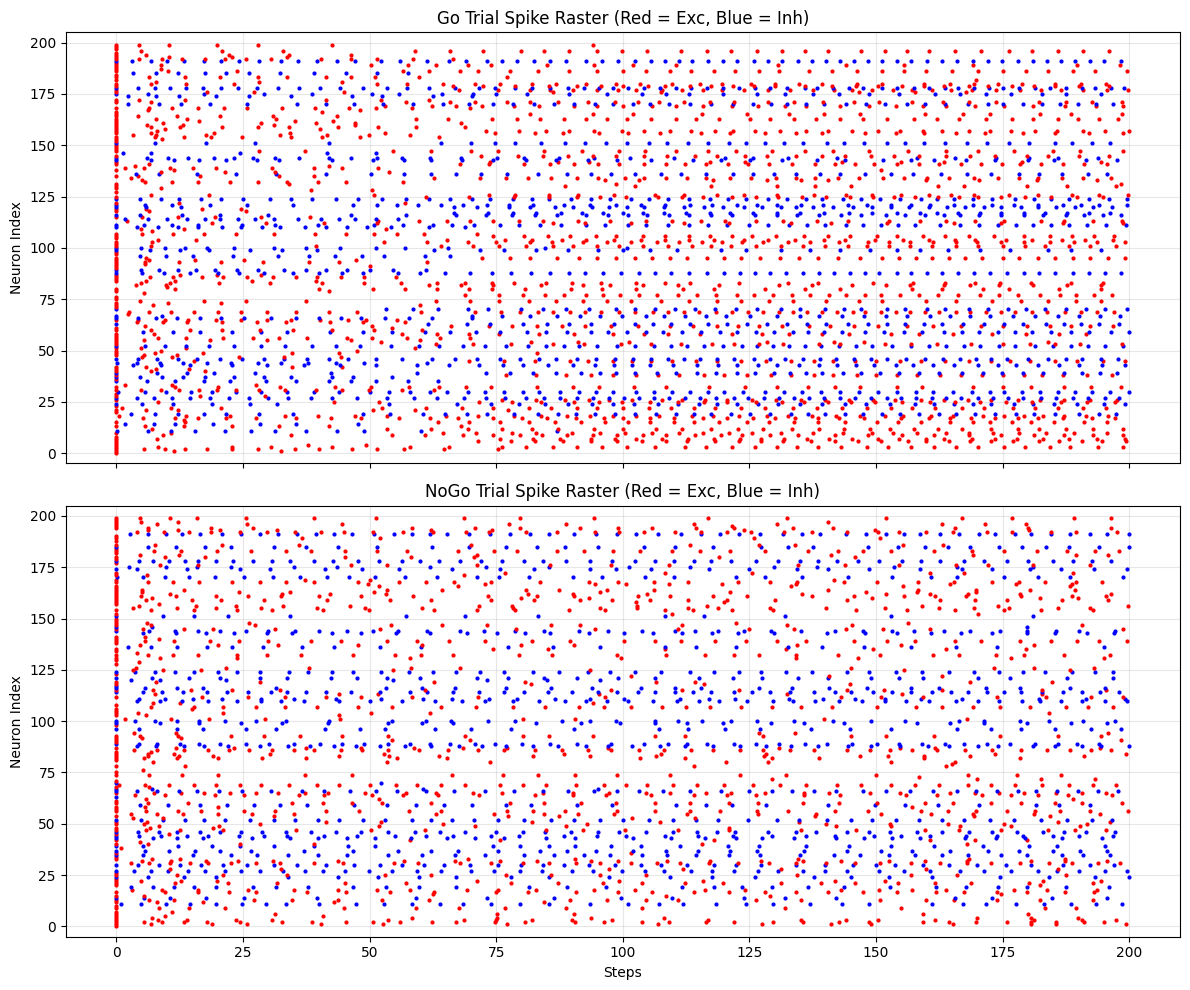

In [15]:
# Build masks for excitatory vs. inhibitory units
model_data = sio.loadmat(model_path)
inh_mask   = model_data['inh'].flatten().astype(bool)   # True  for inhibitory
exc_mask   = model_data['exc'].flatten().astype(bool)   # True  for excitatory
N_total    = int(model_data['N'].item())

# Convenience: function to draw a raster
def plot_raster(spk_mat, title, ax):
    """
    spk_mat : N x T binary spike matrix
    ax      : matplotlib axis
    """
    for n_idx in range(N_total):
        # spike times for neuron n_idx
        spike_times = t_spk[spk_mat[n_idx, :] > 0]
        if spike_times.size == 0:   # skip if no spikes
            continue
        color = 'b' if inh_mask[n_idx] else 'r'
        ax.plot(spike_times,
                np.full_like(spike_times, n_idx),
                '.', color=color, markersize=4)

    ax.set_ylim(-5, N_total + 5)
    ax.set_ylabel('Neuron Index')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

# Draw Go and NoGo rasters
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

plot_raster(spk_go,   'Go Trial Spike Raster (Red = Exc, Blue = Inh)',   axes[0])
plot_raster(spk_nogo, 'NoGo Trial Spike Raster (Red = Exc, Blue = Inh)', axes[1])

axes[1].set_xlabel('Steps')
plt.tight_layout()
plt.show()

## Conclusion

* The **spiking LIF network** reproduces the behaviour of the trained **rate network** on Go-NoGo trials.  
* Spike rasters reveal task-specific activity patterns across excitatory (red) and inhibitory (blue) populations.

You can now adapt the same workflow to other tasks (XOR, Mante, etc.) or explore different scaling factors with `lambda_grid_search` for further optimisation. Happy modelling!